In [1]:
# MEMBER 3 - Habiba Ayman — Data Cleaning & Validation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")

In [2]:
# Step 0 — Load Raw Data
crashes_url = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=download"
persons_url = "https://data.cityofnewyork.us/api/views/f55k-p6yu/rows.csv?accessType=download"

df_crashes = pd.read_csv(crashes_url, low_memory=False)
df_persons = pd.read_csv(persons_url, low_memory=False)

df_crashes.head()
df_persons.head()

,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,PERSON_TYPE,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,EJECTION,...,BODILY_INJURY,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PED_LOCATION,PED_ACTION,COMPLAINT,PED_ROLE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX
0,10249006,4229554,10/26/2019,9:43,31aa2bc0-f545-444f-8cdb-f1cb5cf00b89,Occupant,Unspecified,19141108.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,U
1,10255054,4230587,10/25/2019,15:15,4629e500-a73e-48dc-b8fb-53124d124b80,Occupant,Unspecified,19144075.0,33.0,Not Ejected,...,Does Not Apply,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F
2,10253177,4230550,10/26/2019,17:55,ae48c136-1383-45db-83f4-2a5eecfb7cff,Occupant,Unspecified,19143133.0,55.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,M
3,6650180,3565527,11/21/2016,13:05,2782525,Occupant,Unspecified,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Notified Person,NaN,NaN,NaN
4,10255516,4231168,10/25/2019,11:16,e038e18f-40fb-4471-99cf-345eae36e064,Occupant,Unspecified,19144329.0,7.0,Not Ejected,...,Does Not Apply,Right rear passenger or motorcycle sidecar pas...,Lap Belt,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F


In [3]:
# Step 1 — Backup & Normalize Columns
df_crashes_raw = df_crashes.copy()
df_persons_raw = df_persons.copy()

def normalize_cols(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

df_crashes = normalize_cols(df_crashes)
df_persons = normalize_cols(df_persons)

print("Columns normalized.")

Columns normalized.


In [4]:
# Step 2 — Crash Dataset Cleaning

# Convert crash date and time
df_crashes['crash_date'] = pd.to_datetime(df_crashes['crash_date'], errors='coerce')
df_crashes['crash_time'] = pd.to_datetime(df_crashes['crash_time'], format='%H:%M', errors='coerce').dt.time

# Create time features
df_crashes['crash_hour'] = pd.to_datetime(df_crashes['crash_time'].astype(str), errors='coerce').dt.hour
df_crashes['crash_year'] = df_crashes['crash_date'].dt.year
df_crashes['crash_month'] = df_crashes['crash_date'].dt.to_period('M').astype(str)

# Convert injury/fatality columns to numeric
injury_cols = [c for c in df_crashes.columns if ("injured" in c or "killed" in c)]
for col in injury_cols:
    df_crashes[col] = pd.to_numeric(df_crashes[col], errors='coerce').fillna(0).astype(int)

# Replace missing borough
df_crashes['borough'] = df_crashes['borough'].fillna('Unknown')

# Remove duplicate rows
df_crashes = df_crashes.drop_duplicates()

df_crashes.head()

print("Crash data cleaned. Shape:", df_crashes.shape)

/tmp/ipython-input-1862726669.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_crashes['crash_hour'] = pd.to_datetime(df_crashes['crash_time'].astype(str), errors='coerce').dt.hour


Crash data cleaned. Shape: (2221796, 32)


In [5]:
# Step 3 — Persons Dataset Cleaning

# Age cleaning
df_persons['person_age'] = pd.to_numeric(df_persons['person_age'], errors='coerce')
df_persons.loc[df_persons['person_age'] <= 0, 'person_age'] = np.nan
df_persons.loc[df_persons['person_age'] > 110, 'person_age'] = np.nan

# Impute missing ages
global_median = df_persons['person_age'].median()
median_by_type = df_persons.groupby('person_type')['person_age'].median()

def impute_age(row):
    if pd.notna(row['person_age']):
        return row['person_age']
    pt = row['person_type']
    if pt in median_by_type and not np.isnan(median_by_type.loc[pt]):
        return median_by_type.loc[pt]
    return global_median

df_persons['person_age_imputed'] = df_persons.apply(impute_age, axis=1)

# Sex cleaning
df_persons['person_sex'] = (
    df_persons['person_sex'].astype(str).str.upper().replace({
        'MALE':'M','FEMALE':'F','U':np.nan,'UNKNOWN':np.nan
    })
)
df_persons['person_sex'] = df_persons['person_sex'].where(df_persons['person_sex'].isin(['M','F']), np.nan)

# Person type formatting
df_persons['person_type'] = df_persons['person_type'].astype(str).str.upper()

# Injury category cleaning
def clean_injury(x):
    if pd.isna(x): return "UNKNOWN"
    s = str(x).upper()
    if "KILLED" in s: return "KILLED"
    if "INJUR" in s: return "INJURED"
    if "NONE" in s: return "NONE"
    return "UNKNOWN"

df_persons['person_injury_clean'] = df_persons['person_injury'].apply(clean_injury)

# Remove duplicate rows
df_persons = df_persons.drop_duplicates()

print("Persons data cleaned. Shape:", df_persons.shape)

Persons data cleaned. Shape: (5824319, 23)


In [6]:
# Step 4 — Save Cleaned Data
df_crashes.to_csv("df_crashes_cleaned.csv", index=False)
df_persons.to_csv("df_persons_cleaned.csv", index=False)

print("Cleaned datasets exported.")

Cleaned datasets exported.


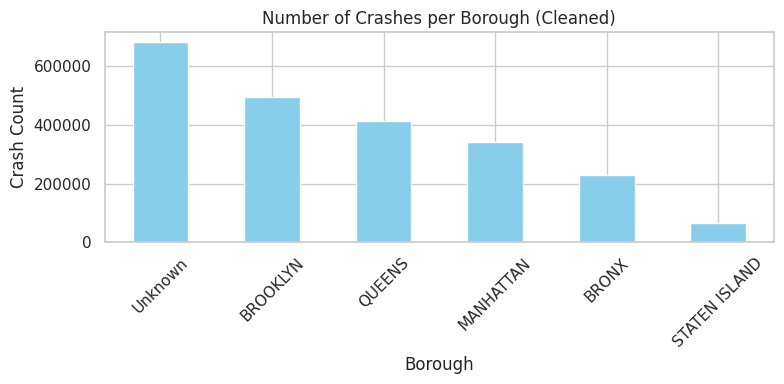

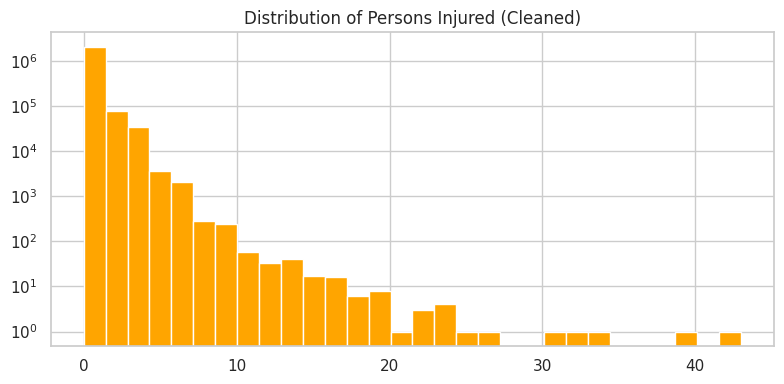

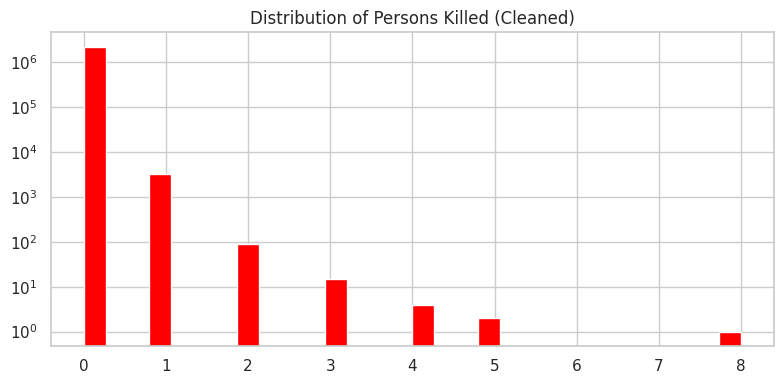

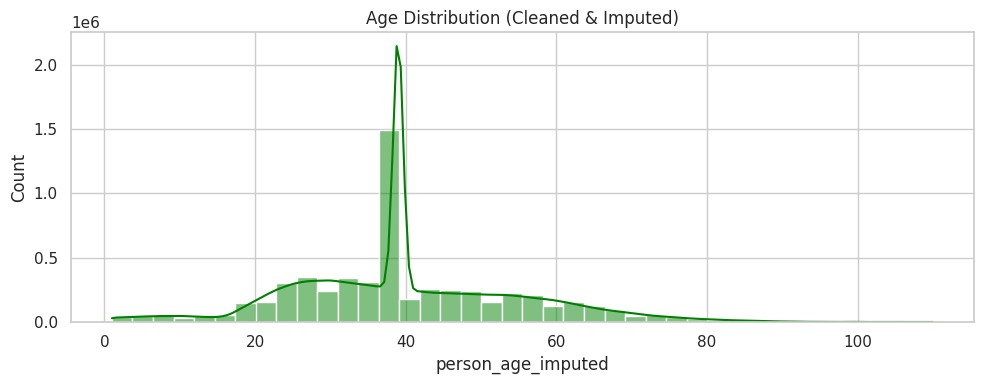

/tmp/ipython-input-123605065.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='person_sex', data=df_persons, palette='pastel')


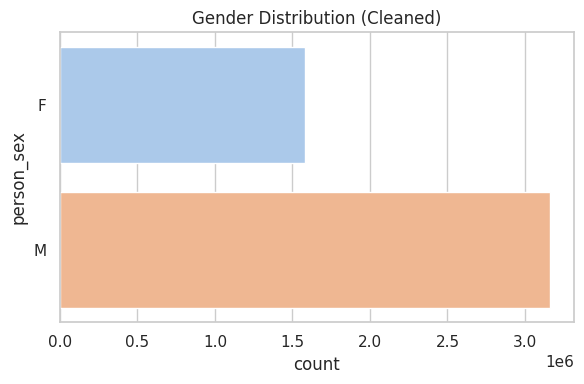

/tmp/ipython-input-123605065.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='person_type', data=df_persons, palette='muted')


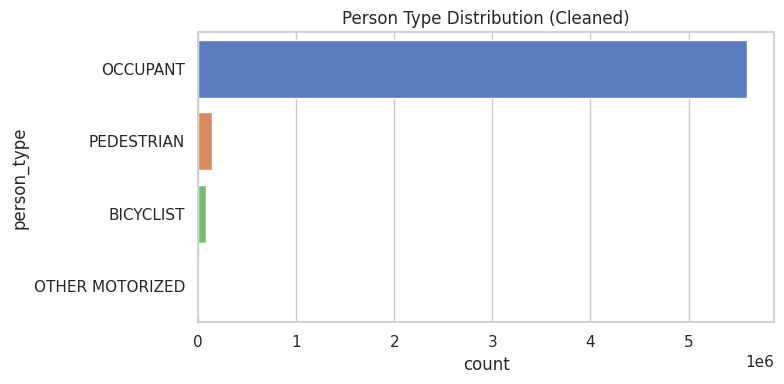

In [7]:
# Step 5 — Validation Visualizations

# Crash counts per borough
plt.figure(figsize=(8,4))
df_crashes['borough'].value_counts().plot(kind="bar", color='skyblue')
plt.title("Number of Crashes per Borough (Cleaned)")
plt.xlabel("Borough")
plt.ylabel("Crash Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Injury distributions
plt.figure(figsize=(8,4))
df_crashes['number_of_persons_injured'].hist(bins=30, color='orange')
plt.yscale("log")
plt.title("Distribution of Persons Injured (Cleaned)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
df_crashes['number_of_persons_killed'].hist(bins=30, color='red')
plt.yscale("log")
plt.title("Distribution of Persons Killed (Cleaned)")
plt.tight_layout()
plt.show()

# Age distribution
plt.figure(figsize=(10,4))
sns.histplot(df_persons['person_age_imputed'], bins=40, kde=True, color='green')
plt.title("Age Distribution (Cleaned & Imputed)")
plt.tight_layout()
plt.show()

# Gender distribution
plt.figure(figsize=(6,4))
sns.countplot(y='person_sex', data=df_persons, palette='pastel')
plt.title("Gender Distribution (Cleaned)")
plt.tight_layout()
plt.show()

# Person type distribution
plt.figure(figsize=(8,4))
sns.countplot(y='person_type', data=df_persons, palette='muted')
plt.title("Person Type Distribution (Cleaned)")
plt.tight_layout()
plt.show()

In [8]:
# Step 6 — Create Sample Datasets (1000 Rows for GitHub)

# Take 1000 random rows from cleaned crashes
sample_crashes = df_crashes.sample(n=1000, random_state=42)
sample_crashes.to_csv("sample_crashes.csv", index=False)

# Take 1000 random rows from cleaned persons
sample_persons = df_persons.sample(n=1000, random_state=42)
sample_persons.to_csv("sample_persons.csv", index=False)

print("Sample files created: sample_crashes.csv, sample_persons.csv")

Sample files created: sample_crashes.csv, sample_persons.csv


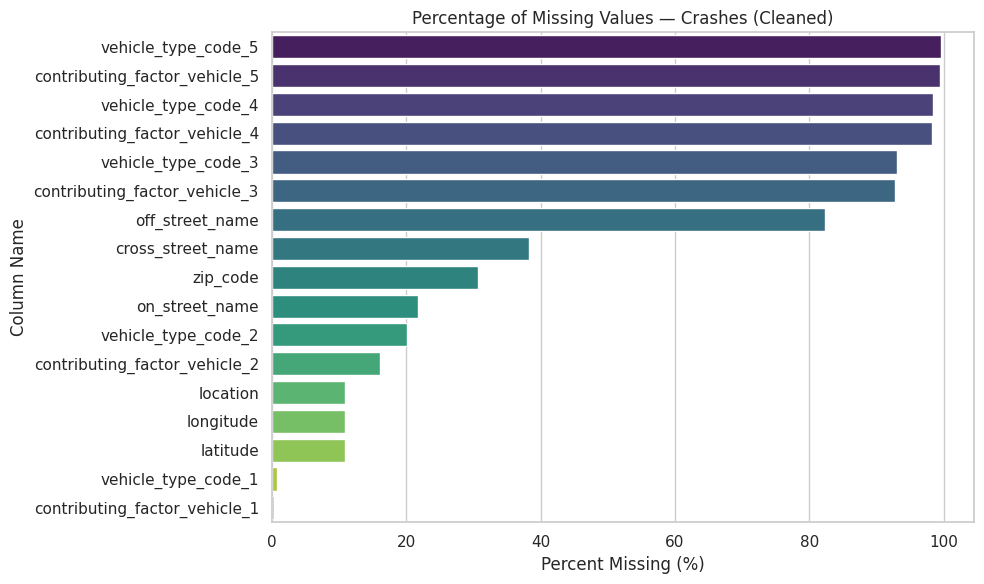

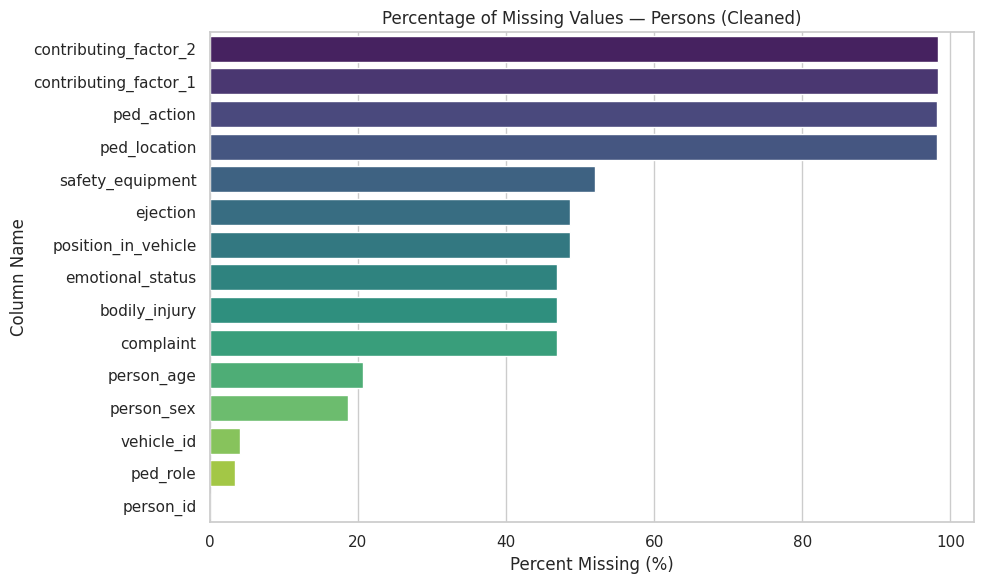

In [9]:
# Missing Values Bar Plot
def plot_missing_percentages(df, title):
    missing_percent = df.isnull().sum() * 100 / len(df)
    missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

    if not missing_percent.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=missing_percent.values, y=missing_percent.index,
                    hue=missing_percent.index, palette='viridis', legend=False)
        plt.title(f"Percentage of Missing Values — {title}")
        plt.xlabel("Percent Missing (%)")
        plt.ylabel("Column Name")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No missing values found in {title}.")

plot_missing_percentages(df_crashes, "Crashes (Cleaned)")
plot_missing_percentages(df_persons, "Persons (Cleaned)")

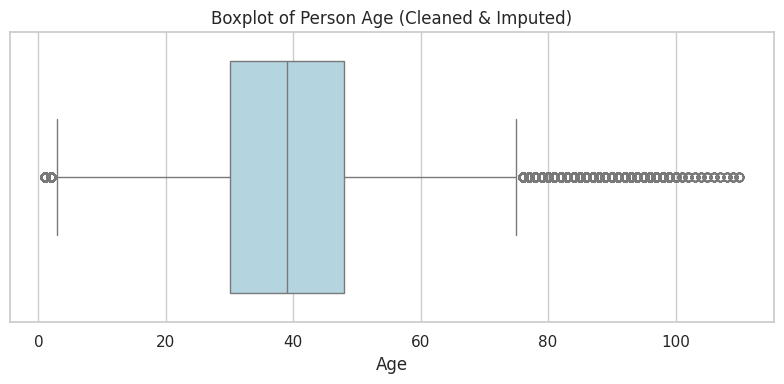

In [10]:
# Age Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x='person_age_imputed', data=df_persons, color='lightblue')
plt.title("Boxplot of Person Age (Cleaned & Imputed)")
plt.xlabel("Age")
plt.tight_layout()
plt.show()

In [11]:
# Check persons linked to missing crashes
missing_crash_ids = df_persons[~df_persons['collision_id'].isin(df_crashes['collision_id'])]
print("Number of persons linked to missing crash IDs:", missing_crash_ids.shape[0])

Number of persons linked to missing crash IDs: 0


# **Member 3 — Data Cleaning, Validation & Standardization Summary**
## 1. Objectives & Scope

Member 3 focused on transforming the raw crashes and persons datasets into a clean, validated, standardized form suitable for merging and deeper analysis. This stage ensured the data is accurate, consistent, and free of structural errors. Key objectives included:

- Standardizing column names and formats

- Cleaning timestamps and generating usable time features

- Handling missing values, invalid entries, and inconsistencies

- Standardizing demographic fields (age, sex, injury category, person type)

- Removing duplicates and validating record integrity

- Producing validation graphs to confirm successful cleaning

- Delivering cleaned datasets ready for Member 4

# 2. Crash Dataset Cleaning

Major steps performed on the crashes dataset included:

- Converting crash_date to proper datetime format

- Parsing crash_time and extracting crash_hour, crash_month, and crash_year

- Ensuring all injury/fatality fields were numeric and filling missing values with zeros

- Standardizing borough data and replacing missing entries with "Unknown"

- Removing duplicate crash records to ensure dataset integrity

- Verifying cleaned distributions using bar charts and histograms

# 3. Persons Dataset Cleaning

Cleaning the persons dataset required extra validation due to demographic inconsistencies. Key tasks included:

- Converting age to numeric, removing invalid values (<0 or >110), and imputing missing ages using medians

- Standardizing sex values to M and F, treating unknowns as missing

- Normalizing person type to consistent uppercase categories

Cleaning injury categories to the standardized labels:

1- NONE

2- INJURED

3- KILLED

4- UNKNOWN

5- Dropping duplicate entries

6- Creating validation plots for gender, age, injury distribution, and person type

# 4. Post-Cleaning Validation & Quality Checks

To verify the cleaning process, multiple diagnostic visualizations were produced:

- Borough-wise crash counts

- Injury/fatality histograms on the cleaned dataset

- Age distribution (raw vs. imputed)

- Gender and person type distribution

- Missing-values barplots for both datasets

- Age boxplot to check remaining outliers

Collision-ID integrity check confirming:
- 0 persons referenced a missing crash

These checks confirmed that both datasets are standardized, consistent, and ready for merging.

# 5. Handover to Member 4

Member 3 delivered:

- df_crashes_cleaned.csv

- df_persons_cleaned.csv

- Full documentation of cleaning decisions

- All validation graphs

- Confirmation that collision IDs align perfectly between datasets

Member 4 can now safely merge datasets, engineer features, and perform final analysis using the cleaned master files.